In [19]:
import pickle
import os

FOLDER = os.getcwd() + "/7cells_blurry"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    psf = pickle.load(file)


In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np
from scipy import fftpack
from scipy.ndimage import gaussian_filter
from utils import GetMidPts, InverseMatrix, GetAvgIntensityWithMask
import cv2


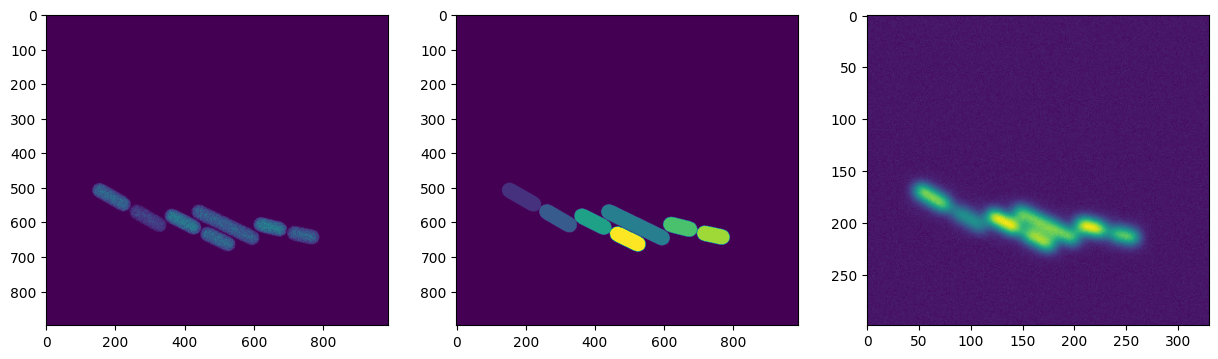

In [21]:
ori = ori/max(ori.flatten())
mask = mask/max(mask.flatten())
out = out/max(out.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

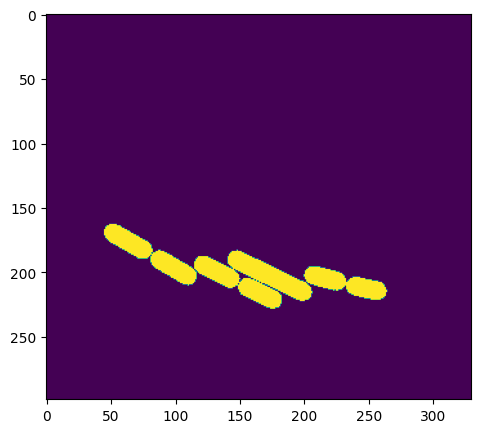

In [22]:
#Apply gaussian filter to out

outBlur = gaussian_filter(out, sigma=1)
plt.imshow(outBlur)

#Resize mask to match out
maskRescale = cv2.resize(mask, outBlur.shape[::-1], interpolation = cv2.INTER_NEAREST)

#IMPT: All mask values are set to one
maskUnit = maskRescale.copy()

for i in range(len(maskUnit)):
    for j in range(len(maskUnit[0])):
        if (maskUnit[i][j] != 0):
            maskUnit[i][j] = 1

plt.imshow(maskUnit)

In [23]:
midPts = GetMidPts(mask)
recoveredImage = InverseMatrix(out, maskRescale, midPts, adjPts=0, learningRate = 1, psf=psf)

[0.14285715, 0.2857143, 0.42857143, 0.5714286, 0.71428573, 0.85714287, 1.0]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]


/home/boomalope/anaconda3/envs/symbac/SyMBac/tests/dx_test_env/utils.py:282: RuntimeWarning: invalid value encountered in divide
  x_bar = x_bar/max(x_bar)


IndexError: index 528 is out of bounds for axis 0 with size 299

/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/boomalope/anaconda3/envs/symbac/lib/python3.11/sit

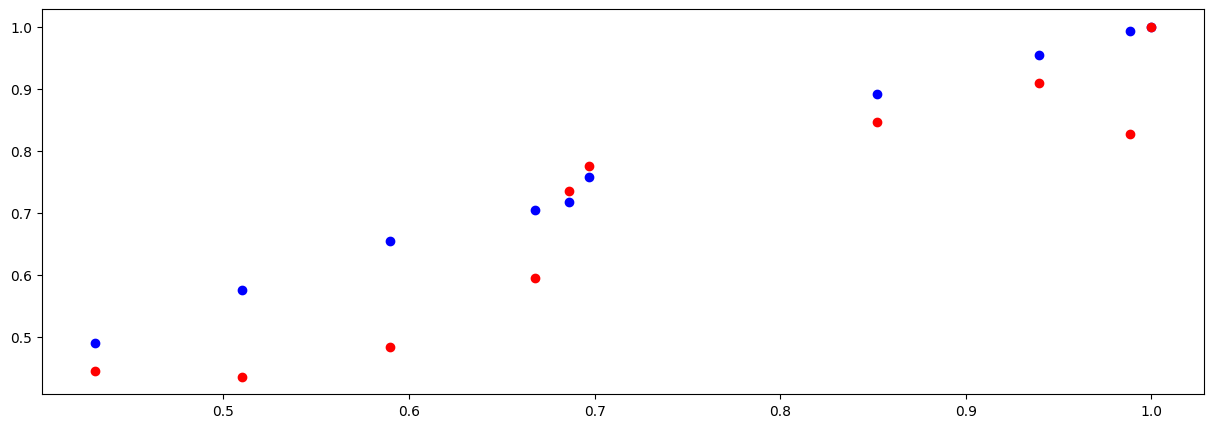

Default:  [[1.         0.99805942]
 [0.99805942 1.        ]]
Custom:  [[1.         0.93402146]
 [0.93402146 1.        ]]


In [ ]:
#Get average intensity in each mask

average_original_mask, average_original_intensity = GetAvgIntensityWithMask(ori,mask)
average_output_mask, average_output_intensity = GetAvgIntensityWithMask(out,mask)
average_custom_mask, average_custom_intensity = GetAvgIntensityWithMask(recoveredImage,mask,midPts)

assert(average_custom_intensity.all()==average_original_intensity.all())
assert(average_output_intensity.all()==average_original_intensity.all())

plt.plot(average_original_intensity,average_output_intensity,'bo')
plt.plot(average_original_intensity,average_custom_intensity,'ro')
plt.show()

#Calculate correlation coefficient
print("Default: ", np.corrcoef(average_original_intensity,average_output_intensity))
print("Custom: ", np.corrcoef(average_original_intensity,average_custom_intensity))